### Use for GMM
The folowing import statement is required to avoid a warning when we use the GMM. There is a memory leakge when we use GMM. 
Do not use it for other entropy approzimations because it slows down the campaign in general. 


In [28]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [29]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bumps

from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty
from bumps.bounds import BoundedNormal
from bumps.bounds import Bounded
from bumps.bounds import Unbounded

from bumps.names import Curve, FitProblem
from bumps.fitproblem import BaseFitProblem
from datastruct import Settings, Experiment, ExperimentStep, DataPoint

from functions import NSE_echo, AutoPar


from bumps.initpop import generate
from bumps.fitters import DreamFit, ConsoleMonitor

from scipy.stats import poisson


# 0. The Variables that Change 
Convention for naming. 
first number(s) represent the row in the table (Excel or Word file, etc) with the specific setting of the row. 
then it folloes a letter with a number. The letter and the number represents the type of approximation
e1 -> Entropy selecting A as the parameter of interest.
e2 -> Entropy selecting all parameters 
o1 -> On-the fly using the first acquisation function 
o2 -> On-the-fly using the second acquisation function 

optional I am thinking about including the type of method that was used to compute the entropies associated with the experiments (mvn, mvn_fast, and gmm). Besides that, I am planning to include  "(x)" where x represents the time it was run. For instance, (3) means that is the third time that we run the same experiment. 


In [30]:
# method of calculating entropy. Can also be gmm, but is very slow without changing the code a bit; talk to David first
#choices: 'mvn_fast' 'mvn' 'gmm'
H_method = 'gmm'

#Id is used in the experimet name and in the name of the saved file
id_entropy1 = "1e1_GMM"  #For specific parameter A
id_entropy2 = "1e2_GMM"   #All parameters
id_on_the_fly1 ="1o1_GMM"  #Using the first acquisation function for On-the-fly
id_on_the_fly2 = "1o2_GMM"
id_control = "1c_GMM"      #Control Data

#Names for the Expriment objects
name_exp_entropy1 = 'gaussian GMM entropy id'+id_entropy1
name_exp_entropy2 = 'gaussian GMM id'+id_entropy2
name_exp_on_the_fly1='gaussian GMM on-the-fly id'+id_on_the_fly1
name_exp_on_the_fly2 = 'gaussian GMM on-the-fly id'+id_on_the_fly2
name_control = 'gaussian GMM Control id'+ id_control

# define possible measurement space
interval_x = 5 
x_left = -450
x_right= 450

###################### MEASUREMENT SPACE#####################
#We include this section here, so you can see how interval_x and x_left work
x = np.arange(x_left, x_right+ interval_x, interval_x)
#Control Points  
datax_control = np.arange(x_left, x_right + 45, 45)

n_control_points = len(datax_control)

#Another option for setting the  
#datax_control = x[::int(45/interval_x)] 
##############################################################

#Changing values 
signal_to_noise_ratio = 0.50   # Varies from 0.05 to 0.95.
cps = 30 #Avg rate "count per second"

agressive_factor = 0.32 #Use in figure_of_merit function. Use 0.32 as a default unless specified
                        #So the actual value used is 0.68. This value is also used in the updated version of 
                        #the acquisition functions for on-the-fly


In [31]:
#They are keep unchange but later we may change these values 
# problem setup: change these to change ground truth model
sigma = 797.0
true_period = 401.0
true_phase0 = 155.0



In [32]:
#This is so the entropy in the control data is better than the autonomous cases
control_constant = 7000 #7000 for (-450,540)if sgr >0.2 othersise a samller value can make the trick as well, 
                                                        #8000 for (-900,900),
                                                        #17000(or less) for (-1800,1800) and makes a good job


1. Define physics model function
2. Define the (simulated) measurement function   
   2.1 if simulated: Define the ground truth.     
3. Define the ML model based on the physics model using MCMC    
   3.1 Define the prior distributions  
   3.2 Define how to use the physics model  
4. Define how MCMC samples the prior
5. Define an acquistion function
6. Choose a first point
7. For i: #Run Active Learning Campaign    
    7.1 (simulated) measurement
    7.2 Run the MCMC inference  
    7.3 Choose the next point using acquistion function  
    7.4 (optional) Check for stopping criteria  


# 1 Define the Ground Truth

In [33]:
# derived "true parameters"
truepar_dict = {'I0': cps,
                'A': signal_to_noise_ratio * cps,
                'phi0': true_phase0,
                'T': true_period,
                'sigma': sigma}

# 2 Define the ML model based on the physics model using MCMC

## 2.1 Define the Prior Distributions

In [34]:
I0_guess = 25.5 #[n/s]  truepars[0]
I0_lo = truepar_dict["I0"]/30.
I0_hi = truepar_dict["I0"]*30

A_guess = 10.5   #[n/s] I modified this value before it was 500, but that would be outside the possible values
A_lo = truepar_dict["I0"]/1000.
A_hi = truepar_dict["I0"]*2

phi0_guess = 0.0  # [deg]
phi0_lo = -800.
phi0_hi = 800.

sigma_guess = sigma
# sigma_limits = (sigma,sigma) #Zero-with distibution at the moment, we know this one

T_guess = 200. #[deg]
T_lo = 300.
T_hi = 500.

# define parameters. 
#Note: the class AutoPar is stored in the Functions file 
Apar = AutoPar(name = 'A', value=A_guess, bounds=(A_lo, A_hi))
I0par = AutoPar(name='I0', value= I0_guess, bounds=(I0_lo, I0_hi))
phi0par = AutoPar(name='phi0', value=phi0_guess, bounds=(phi0_lo,phi0_hi ))
sigmapar = AutoPar(name='sigma', value=sigma)
Tpar = AutoPar(name='T', value= T_guess, bounds=(T_lo,T_hi ))


## 2.2 Define how to use the physics model

In [35]:
# define function object
nse_echo = NSE_echo(x, Apar, I0par, phi0par, sigmapar, Tpar) 

# 3. Simulation Functions

In [36]:
#The Simulated Measurement Function
def new_points(newx, x, truey, meastime):
    """ Function for generating new data points

        Inputs:
        newx -- x position of new data point(s) [deg]
        x -- function space [deg]
        truey -- ground truth counting rate [n/s]; same shape as x
        meastime -- measurement times for the new data points [s]
        
        Returns:
        newy -- y(newx): function values [n/s]
        newdy -- dy(newx): function uncertainties [n/s]
    
    """

    # calculate target counts from ground truth rate and measurement time
    mu = np.interp(newx, x, truey) * meastime #avf number count. It will be used as the poisson parameter 
    
    # pick new points from poisson distribution
    newy = np.array(poisson.rvs(mu), ndmin=1, dtype=float) #[n]
    newdy = np.sqrt(newy) #[n] this is the standard deviation of the Poisson process
    newdy[newdy==0] = 1 
    print(newy, newdy)

    return newy / meastime, newdy / meastime #[n/s] 

#A helper function
def flatten(a):
    """ Super flatten"""

    return np.array([ia for alist in a for ia in alist])




In [37]:
#Helper function
#Define function for calculating y(x) from parameter sets sampled from prior or posterior distribution functions
def sampler(problem: BaseFitProblem, x, pts):
    """ Function for generating y(x) curves from MCMC samples
    
        Inputs:
        problem -- FitProblem object containing the theory curve
        x -- the function space, with dimension X [deg]
        pts -- list or array of MCMC samples (i.e. parameter vectors), dimension N (number of samples) x P (number of parameters)
                array[units of parameter]
        Returns:
        ys -- an N x X array containing y(x) for each MCMC sample
    """
    ys = list()
    for v in pts:
        # set the parameters
        problem.setp(v)

        # calling chisq_str updates the model
        problem.chisq_str()

        # calculate the updated theory curve
        y = problem.fitness.theory(x) #[n/s]
        ys.append(y)
        
    return np.array(ys)

    

# 4 Define Acquistion functions for Both Apporaches

##     4.1 Entropy Functions


In [38]:
from entropy import calc_entropy, default_entropy_options

## 4.2 Figure of Merit for Entropy Approach 

The figure of merit is dH/dT. We pick as the new point the one with the greastest value. Remember, we have 3 ways to compute the entropy, MVN, MVN_FAST, and GMM. Thus, we have two options for calculating the Figure of Merit (FOM) for the entropy approach. Howver, notice that we will use the same method to compute the entropy at the different iterations for On-the fly.The On-the-fly approach will store its entropy values calculated using the same estimator. Thus, make sure you are using the same entropy estimator. 

In [39]:
from bumps.dream.stats import credible_interval

def movetime(xs, curx=None):
    # hardcoded 6 seconds move time, unless we stay in the same place
    mt = np.full_like(xs, 6.0)
    if curx is not None:
        mt[xs==curx] = 0.0
    return mt

def figure_of_merit(xs, yprofs, pts, agressi_factor, curx=None, sel=None, min_meastime=0.0,options=default_entropy_options, predictor=None):
    """ Function for calculating the figure of merit based on the change in information (\DeltaH)
    
        Inputs:
        xs -- function space (dimension X)
        yprofs -- y(x) array, e.g. from "sampler", dimension N (number of samples) x X
        pts -- MCMC samples, dimension N x P (number of parameters)
        sel -- if None, all parameters are used; otherwise an array of parameters of interest for marginalization

        Returns:
        dH -- array (dimension X) of \DeltaH for each x in the function space
        relsig -- relative error at each point in the function space (not generally useful, only used for this example)
        predictor -- a predictor object use only when you are using GMM to estimate the entropies
    """

    H0, _, predictor = calc_entropy(pts, select_pars=sel, options=options, predictor=predictor)
    if predictor is not None:
        predictor.warm_start=True

    dH = list()
    relsig = list()
    meastimes = list()
    movetimes = movetime(xs, curx)
    min_pts, max_pts = None, None

    # step through function space and calculate dH at each point. Note that this can be done more efficiently with
    # np.argsort over the entire xs space.
    for idx, (x, mt) in enumerate(zip(xs, movetimes)):
        iqs = yprofs[:,idx]
        iqs_sorted = np.sort(iqs)
        
        # calculate median and CI. This can be done more efficiently and over the whole xs array with np.argsort
        med, ci = credible_interval(iqs_sorted, (0, 1-agressi_factor)) 
        med = med[0]
        eff_sigma = 0.5 * np.diff(ci)[0]

        # assume the count rate will be the median rate. Then for Poisson statistics the time required to constrain
        # the model is:
        meastime = 1./(med * (eff_sigma / med)**2)
        meastime_clip = max(min_meastime, meastime)

        # select points in the CI and calculate the entropy of selected points
        crit = (iqs > ci[0]) & (iqs < ci[1])
        #r1idxs = np.arange(len(crit))[crit]
        iH, _, _ = calc_entropy(pts[crit, :], select_pars=sel, options=options, predictor=predictor)

        # calculate dH/dt and relative error
        dHdt = (H0 - iH) / (meastime)

        # calculate expected dH in minimum measurement time
        dH_projected = dHdt * meastime_clip

        # calculate effective dH/dt given movement time
        dH.append(dH_projected / (meastime_clip + mt))
        relsig.append(eff_sigma / med)
        meastimes.append(meastime)
        if dH[-1] == max(dH):
            max_pts = pts[crit, :]
        elif dH[-1] == min(dH):
            min_pts = pts[crit, :]


    return np.array(dH), (min_pts, max_pts), np.array(meastimes), np.array(movetimes), H0, predictor



## 4.3 Figure of Merit Functions for for On-the-fly Approach

 
We want a function that compairs the model uncertainty (Confidence Interval of posterior of the model)to the predicted measurement uncertainty (what would the measurement error be if we measured at that location for a given time). Find the point in x (angle) where the ratio decrease by a factor in the shortest time. User specifies the factor. Return  the figure of merits for the x values, then you choose the value of x and the count time needed to decrease ratio by the factor.       

We have 2 options for computing the figure of merit for the On-the-fly approach. 

In [40]:
# def uncertainty_acquire_first(x, yprofs, this_curr_x):
#     """ An acquisition function based on Uncertainty in the predictions for the on-the-fly-approach 
    
#         Inputs:
#         x -- the function space, with dimension X [deg]
#         yprofs -- y(x) array, e.g. from "sampler", dimension N (number of samples) x X
#         this_curr_x -- it is the current position where we measured. It is used to compute the movement time
        
#         Returns:
#         Notice that all the return lists are parallel for the possible values in the entire measurent space 
        
#         a: an array that contains all the figure of merits. We have to pick the greatest as the optimal point 
#         measure_times: A list that contains all the measurement times.
#         movement_time: A list that contains all the movement times 
#     """
    
#     yprofs_mean = np.mean(yprofs, axis = 0) #Calculating the mean at a given x point. This have the same dimension as the 
#                                             #x, function space. Units [n/s]
#     yprofs_std = np.std(yprofs, axis = 0) # std of y at every x. Model uncertainty [n/s] 
    
#     #Using Poisson distribution, and the fact that the mean and variance are the same, we derived...
#     ## np.sqrt(y_mean*time)/time = y_std
#     ## np.sqrt(y_mean*time) = y_std*time
#     ## y_mean *time = y_std**2 * time**2
#     measure_times = yprofs_mean/ (yprofs_std**2) 
    
#     #Time clip for the measurement times. Making all the  times smaller than min_meastime equal to the meas_time 
#     #measure_times = np.clip(measure_times, min_meastime, None) #ERROR, it causes an error too many points that are ideal
#     #we do not put it here because using the clip_time(minimum time of measuring) is task of the code outside the function 
    
    
    
#     movement_times = movetime(xs = x, curx = this_curr_x)
#     cost = measure_times + movement_times
#     desirability = np.ones(cost.shape)
#     FOMS = desirability/cost #Notice at this point, it is similar to the measure time in dH and dH_gmm
    
#     #next_point = np.max(a)
#     #We comment the code above bc we want this function to work similar to the "figure_of_merits" of the entropy approach. So, 
#     #they behave similarly.
#     return FOMS, measure_times, movement_times
    
    
#     ##On-the-fly Approach Acquisition
#     # Acquisiton function 1
#     #x = the function space
#     #y = all the curves in the function space
#     # y_mean = np.mean(y, axis = 1?) # mean of y at every x value [counts/s]
#     # y_std = np.std(y, axis = 1?) # std of y at every x # model uncertainty [counts/s]
#     # # np.sqrt(y_mean*time)/time = y_std
#     # # np.sqrt(y_mean*time) = y_std*time
#     # # y_mean *time = y_std**2 * time**2
#     # time = y_mean/ y_std**2
#     # desirability = np.ones()
#     # cost = time + movement_time
#     # a = desirabilty/cost
#     # next_point = np.max(a)
#     # return next_point, x[a == next_point], time[a == next_point]

# def uncertainty_acquire_second(x, yprofs, this_curr_x): 
#     """ An acquisition function based on Uncertainty in the predictions for the on-the-fly-approach 
    
#         Inputs:
#         problem -- FitProblem object containing the theory curve
#         x -- the function space, with dimension X [deg]
#         yprofs -- y(x) array, e.g. from "sampler", dimension N (number of samples) x X
#         this_curr_x -- it is the current position where we measured. It is used to compute the movement time
        
#         Returns:
#         Notice that all the return lists are parallel for the possible values in the entire measurent space 
        
#         a: an array that contains all the figure of merits. We have to pick the greatest as the optimal point 
#         measure_times: A list that contains all the measurement times.
#         movement_time: A list that contains all the movement times  
#     """
    
#     #In count space (acquistion function 2)
#     # # time = the time needed to improve the model uncertainty by a factor (sqrt(2)). 
#     yprofs_mean = np.mean(yprofs, axis = 0) #Calculating the mean at a given x point. This have the same dimension as the 
#                                             #x, function space. Units [n/s]
#     yprofs_std = np.std(yprofs, axis = 0) # std of y at every x. Model uncertainty [n/s] 
    
#     measure_times = yprofs_mean/ (yprofs_std**2) 
    
#     #Do not use the code below. You may be tented to use the minimum measurement here. If you do you will get many optimal 
#     #points. You apply the min measumeremt time after you picked a point when you are simulating a value given that you measure 
#     #for that time. 
#     #measure_times = np.clip(measure_times, min_measure_time, None)
#     #Time clip for the measurement times. 
#     #measure_times = np.clip(measure_times, min_meastime, None) #it causes an error too many points that are ideal 
 
#     movement_times = movetime(xs = x, curx = this_curr_x)
    
#     Y = yprofs_mean*measure_times

#     Y_std = yprofs_std*measure_times
#     desirability = Y_std / np.sqrt(Y) # ratio of the predicted measurement uncertainty/model uncertainty
#     cost = measure_times + movement_times
#     FOMS = desirability/cost
    
#     #next_point = np.max(a)
    
#     return FOMS, measure_times, movement_times

#     #Austin's Pseudocode
#     # time = y_mean / y_std**2
#     # Y = y_mean*time
#     # desirablity = Y_std / np.sqrt(Y) # ratio of the predicted measurement uncertainty/model uncertainty
#     # cost = time + movement_time 
#     # a = desirabilty/cost
#     # next_point = np.max(a)
#     # return next_point, x[a == next_point], time[a == next_point]
    

### New version 
It has not been used to compute data yet. You add the same block of "new" code to the second acquisation function for on-the-fly and get a new version

In [41]:
def uncertainty_acquire_first(x, yprofs, this_curr_x = None, this_agressive_factor = 0.32):
    #### NEW
    yprofs_mean = []
    yprofs_std = []
    for i in range(yprofs.shape[1]):
            med, ci = credible_interval(yprofs[:,i], (0, 1- this_agressive_factor))
            yprofs_mean.append(med[0])
            yprofs_std.append(0.5 * (ci[1]-ci[0]))
            
    yprofs_mean = np.array(yprofs_mean)
    yprofs_std = np.array(yprofs_std)
    ### END NEW

    #yprofs_mean = np.mean(yprofs, axis = 0)
    #yprofs_std = np.std(yprofs, axis = 0)
    measure_times = yprofs_mean/ (yprofs_std**2)

    movement_times = movetime(xs = x, curx = this_curr_x)
    cost = measure_times + movement_times
    desirability = np.ones(cost.shape)
    FOMS = desirability/cost 
   
    return FOMS, measure_times, movement_times


def uncertainty_acquire_second(x, yprofs, this_curr_x = None, this_agressive_factor = 0.32): 
    """ An acquisition function based on Uncertainty in the predictions for the on-the-fly-approach 
    
        Inputs:
        problem -- FitProblem object containing the theory curve
        x -- the function space, with dimension X [deg]
        yprofs -- y(x) array, e.g. from "sampler", dimension N (number of samples) x X
        this_curr_x -- it is the current position where we measured. It is used to compute the movement time
        
        Returns:
        Notice that all the return lists are parallel for the possible values in the entire measurent space 
        
        a: an array that contains all the figure of merits. We have to pick the greatest as the optimal point 
        measure_times: A list that contains all the measurement times.
        movement_time: A list that contains all the movement times  
    """
    
    #In count space (acquistion function 2)
    # # time = the time needed to improve the model uncertainty by a factor (sqrt(2)).
    
    #### NEW
    yprofs_mean = []
    yprofs_std = []
    for i in range(yprofs.shape[1]):
            med, ci = credible_interval(yprofs[:,i], (0, 1- this_agressive_factor))
            yprofs_mean.append(med[0])
            yprofs_std.append(0.5 * (ci[1]-ci[0]))
            
    yprofs_mean = np.array(yprofs_mean)
    yprofs_std = np.array(yprofs_std)
    ### END NEW
    
    
    measure_times = yprofs_mean/ (yprofs_std**2) 
    
    #Do not use the code below. You may be tented to use the minimum measurement here. If you do you will get many optimal 
    #points. You apply the min measumeremt time after you picked a point when you are simulating a value given that you measure 
    #for that time. 
    #measure_times = np.clip(measure_times, min_measure_time, None)
    #Time clip for the measurement times. 
    #measure_times = np.clip(measure_times, min_meastime, None) #it causes an error too many points that are ideal 
 
    movement_times = movetime(xs = x, curx = this_curr_x)
    
    Y = yprofs_mean*measure_times

    Y_std = yprofs_std*measure_times
    desirability = Y_std / np.sqrt(Y) # ratio of the predicted measurement uncertainty/model uncertainty
    cost = measure_times + movement_times
    FOMS = desirability/cost
    
    #next_point = np.max(a)
    
    return FOMS, measure_times, movement_times

    #Austin's Pseudocode
    # time = y_mean / y_std**2
    # Y = y_mean*time
    # desirablity = Y_std / np.sqrt(Y) # ratio of the predicted measurement uncertainty/model uncertainty
    # cost = time + movement_time 
    # a = desirabilty/cost
    # next_point = np.max(a)
    # return next_point, x[a == next_point], time[a == next_point]
    

### Note: 
For the entropy and on-the-fly approaches the units of the figure of merits are different. 

# 5 Setting
Each iteration can be performed by running all cells in section 2.1 and following. The algorithm is:
1. Draw MCMC samples from the previous fit result
2. Calculate y(x) corresponding to each sample
3. Calculate dH/dt(x) as the figure of merit. Note that "speed improvement factor" is over a randomly selected point.
4. Select a new point
5. Simulate data at the new point
6. Run MCMC fit

In [42]:
"""
Initialize data variables
"""

# minimum measurement time (it takes 6 seconds to change phase so this is a reasonable value)
#minimun time to measure any point selected by the different acquisition functions
min_meastime = 5.0

ix = [np.mean(x)] #First random point to measure 

# initially we have not selected a new data point
newx_e1 = None 
newx_e2 = None  
newx_o1 = None 
newx_o2 = None 

In [43]:
"""
Define the settings object
"""
# select parameters of interest from 0: A, 1: I0, 2: T, 3: phi; use None for all parameters
# for NSE, typically only A is of interest
sel = [0]
sel_all = None

# Bumps fit parameters
#I changed alpha from 0. to 0.000001 (values used in previous code)
fit_params = {'burn': 10000, 'steps': 500, 'pop': 10, 'alpha': 0.000001, 'init':'lhs', 'seed': 1000}

# Thinning factor for analysis results
thinning = 25

# entropy options
entropy_options = {'method': H_method, 'n_components': None} #n_components is used by GMM entropy. If None, it uses 
                                                             #the default values. Read the entropy file for more details

#Settings
settings = Settings(truepar_dict, x, fit_params, entropy_options, thinning= thinning, sel=sel)
settings_all = Settings(truepar_dict, x, fit_params, entropy_options, thinning= thinning, sel=sel_all)

In [44]:
#experiments
exp_entropy1 = Experiment(name= name_exp_entropy1, settings=settings, function=nse_echo)
exp_entropy2 = Experiment(name= name_exp_entropy2, settings=settings_all, function=nse_echo)
exp_on_the_fly1 = Experiment(name= name_exp_on_the_fly1, settings=settings, function=nse_echo)
exp_on_the_fly2 = Experiment(name= name_exp_on_the_fly2, settings=settings, function=nse_echo)
exp_control = Experiment(name=name_control, settings=settings, function=nse_echo)

#Some functions of the class Experiment work different for control data
exp_control.control = True 

In [45]:
#Ask David for details. 
from bumps.fitters import DreamFit, _fill_defaults

class DreamFitPlus(DreamFit):
    def __init__(self, problem):
        super().__init__(problem)

    def solve(self, monitors=None, abort_test=None, mapper=None, initial_population=None, **options):
        from bumps.dream import Dream
        from bumps.fitters import MonitorRunner, initpop
        if abort_test is None:
            abort_test = lambda: False
        options = _fill_defaults(options, self.settings)
        #print(options, flush=True)

        if mapper:
            self.dream_model.mapper = mapper
        self._update = MonitorRunner(problem=self.dream_model.problem,
                                     monitors=monitors)

        population = initpop.generate(self.dream_model.problem, **options) if initial_population is None else initial_population
        pop_size = population.shape[0]
        draws, steps = int(options['samples']), options['steps']
        if steps == 0:
            steps = (draws + pop_size-1) // pop_size
        # TODO: need a better way to announce number of steps
        # maybe somehow print iteration # of # iters in the monitor?
        print("# steps: %d, # draws: %d"%(steps, pop_size*steps))
        population = population[None, :, :]
        sampler = Dream(model=self.dream_model, population=population,
                        draws=pop_size * steps,
                        burn=pop_size * options['burn'],
                        thinning=options['thin'],
                        monitor=self._monitor, alpha=options['alpha'],
                        outlier_test=options['outliers'],
                        DE_noise=1e-6)

        self.state = sampler.sample(state=self.state, abort_test=abort_test)

        self._trimmed = self.state.trim_portion() if options['trim'] else 1.0
        #print("trimming", options['trim'], self._trimmed)
        self.state.mark_outliers(portion=self._trimmed)
        self.state.keep_best()
        self.state.title = self.dream_model.problem.name

        # TODO: Temporary hack to apply a post-mcmc action to the state vector
        # The problem is that if we manipulate the state vector before saving
        # it then we will not be able to use the --resume feature.  We can
        # get around this by just not writing state for the derived variables,
        # at which point we can remove this notice.
        # TODO: Add derived/visible variable support to other optimizers
        fn, labels = getattr(self.problem, 'derive_vars', (None, None))
        if fn is not None:
            self.state.derive_vars(fn, labels=labels)
        visible_vars = getattr(self.problem, 'visible_vars', None)
        if visible_vars is not None:
            self.state.set_visible_vars(visible_vars)
        integer_vars = getattr(self.problem, 'integer_vars', None)
        if integer_vars is not None:
            self.state.set_integer_vars(integer_vars)

        x, fx = self.state.best()

        # Check that the last point is the best point
        #points, logp = self.state.sample()
        #assert logp[-1] == fx
        #print(points[-1], x)
        #assert all(points[-1, i] == xi for i, xi in enumerate(x))
        return x, -fx



In [46]:
"""
Sample the prior distribution for initial analysis
"""
#Entropy 1
initproblem_entropy1 = exp_entropy1.make_problem(ix, np.ones_like(ix), np.ones_like(ix))
fitter_entropy1 = DreamFitPlus(initproblem_entropy1)
pts_entropy1 = generate(initproblem_entropy1, init='random', pop=fit_params['pop'] * fit_params['steps'] / thinning) 

#Entropy 2
initproblem_entropy2 = exp_entropy2.make_problem(ix, np.ones_like(ix), np.ones_like(ix))
fitter_entropy2 = DreamFitPlus(initproblem_entropy2)
pts_entropy2 = generate(initproblem_entropy2, init='random', pop=fit_params['pop'] * fit_params['steps'] / thinning)


#On-the-fly 1
initproblem_on_the_fly1 = exp_on_the_fly1.make_problem(ix, np.ones_like(ix), np.ones_like(ix))
fitter_on_the_fly1 = DreamFitPlus(initproblem_on_the_fly1)
pts_on_the_fly1 = generate(initproblem_on_the_fly1, init='random', pop=fit_params['pop'] * fit_params['steps'] / thinning) 

#On-the-fly 2
initproblem_on_the_fly2 = exp_on_the_fly2.make_problem(ix, np.ones_like(ix), np.ones_like(ix))
fitter_on_the_fly2 = DreamFitPlus(initproblem_on_the_fly2)
pts_on_the_fly2 = generate(initproblem_on_the_fly2, init='random', pop=fit_params['pop'] * fit_params['steps'] / thinning)

#Control, we are creating this objet so we can get the initial entropy for the control data. Tecnically, the pts_... should 
#be the same for all the apporaches. 
initproblem_control = exp_control.make_problem(ix, np.ones_like(ix), np.ones_like(ix))
fitter_control = DreamFitPlus(initproblem_control)
pts_control = generate(initproblem_control, init='random', pop=fit_params['pop'] * fit_params['steps'] / thinning)



In [47]:
#computing initial entropies 

##For Entropy 1
exp_entropy1.H0, _, predictor_total_init_e1 = calc_entropy(pts_entropy1, select_pars=None,
                              options=exp_entropy1.settings.entropy_options, predictor=None)
exp_entropy1.H0_marg,_, predictor_marg_init_e1 = calc_entropy(pts_entropy1, select_pars=exp_entropy1.settings.sel, 
                           options=exp_entropy1.settings.entropy_options, predictor=None)

##For Entropy 2
exp_entropy2.H0, _, predictor_total_init_e2 = calc_entropy(pts_entropy2, select_pars=None,
                      options=exp_entropy2.settings.entropy_options, predictor=None)
exp_entropy2.H0_marg = exp_entropy2.H0 #we can assign the total entropy bc this expereiment select all 
                                        #parameters. IMPROVEMENT: We may want to save memory a load time
                                        #by assigning None or not asssigning anything to it 
    
## For On-theFly1
exp_on_the_fly1.H0,_, predictor_total_init_o1 = calc_entropy(pts_on_the_fly1, select_pars=None,
                                              options=exp_on_the_fly1.settings.entropy_options, predictor=None)
exp_on_the_fly1.H0_marg,_, predictor_marg_init_o1 = calc_entropy(pts_on_the_fly1, select_pars=exp_on_the_fly1.settings.sel, 
                                                   options=exp_on_the_fly1.settings.entropy_options, predictor=None)

## For On-theFly2
exp_on_the_fly2.H0,_, predictor_total_init_o2 = calc_entropy(pts_on_the_fly2, select_pars=None,
                                                  options=exp_on_the_fly2.settings.entropy_options, predictor=None)
exp_on_the_fly2.H0_marg, _, predictor_marg_init_o2 = calc_entropy(pts_on_the_fly2, select_pars=exp_on_the_fly2.settings.sel, 
                                                   options=exp_on_the_fly2.settings.entropy_options, predictor=None)

#For Control 
exp_control.H0,_, predictor_total_init_c = calc_entropy(pts_control, select_pars=None,
                                          options=exp_control.settings.entropy_options, predictor=None)
exp_control.H0_marg, _, predictor_marg_init_c = calc_entropy(pts_control, select_pars=exp_control.settings.sel, 
                                                options=exp_control.settings.entropy_options, predictor=None)

In [48]:
truepars = np.array([truepar_dict[key] for key, p in initproblem_entropy1.model_parameters().items() if not p.fixed])    

# number of parameters
npars = len(truepars)

#The lines below may not be needed  since we are initializing the iteration witha new problem  
#initproblem_entropy.setp(truepars)
truey = exp_entropy1.truey()
# initproblem_on_the_fly.setp(truepars)
# initproblem_control.setp(truepars)

Text(0.5, 0.98, 'Ground truth function')

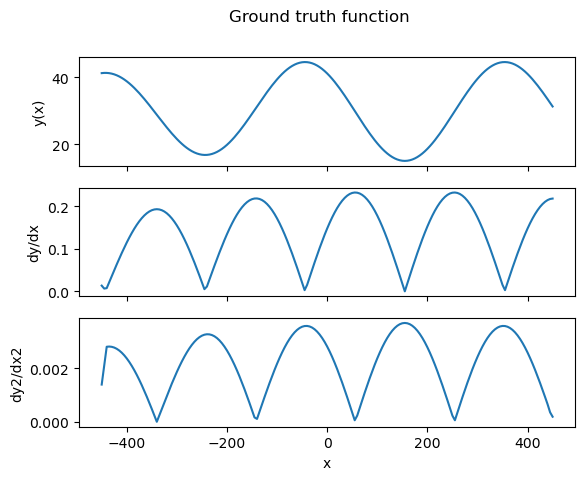

In [49]:
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(x,truey)
ax[0].set_ylabel('y(x)')
dydx = np.gradient(truey) / np.gradient(x)
dydx2 = np.gradient(dydx) / np.gradient(x)
ax[1].plot(x, np.abs(dydx))
ax[1].set_ylabel('dy/dx')
ax[2].plot(x, np.abs(dydx2))
ax[2].set_ylabel('dy2/dx2')
ax[2].set_xlabel('x')
plt.suptitle('Ground truth function')

In [50]:
# Generate initial data (e.g. a single random point or a survey measurement)
npoints = 10
counttime = min_meastime
initdatax = np.linspace(min(x), max(x), npoints, endpoint=False)
initdatax = initdatax + 0.5 * (initdatax[1] - initdatax[0])
initdatax = np.array([0.5 * (min(x) + max(x))])
initdatay, initdatady = new_points(initdatax, initdatax, np.interp(initdatax, x, truey), counttime)

#DO NOT INCLUDE THIS FOR THE CONTROL DATA. All of those points are determined evenly in x. 
data_entropy1 = [DataPoint(x=ix,
                 y=iy,
                 dy=idy,
                 meastime=min_meastime,
                 movetime=0.0) for (ix, iy, idy) in zip(initdatax, initdatay, initdatady)]

data_entropy2 = [DataPoint(x=ix,
                 y=iy,
                 dy=idy,
                 meastime=min_meastime,
                 movetime=0.0) for (ix, iy, idy) in zip(initdatax, initdatay, initdatady)]
                 
data_on_the_fly1 = [DataPoint(x=ix,
                 y=iy,
                 dy=idy,
                 meastime=min_meastime,
                 movetime=0.0) for (ix, iy, idy) in zip(initdatax, initdatay, initdatady)]

data_on_the_fly2 = [DataPoint(x=ix,
                 y=iy,
                 dy=idy,
                 meastime=min_meastime,
                 movetime=0.0) for (ix, iy, idy) in zip(initdatax, initdatay, initdatady)]



exp_entropy1.steps.append(ExperimentStep(points=data_entropy1))
exp_entropy2.steps.append(ExperimentStep(points=data_entropy2))
exp_on_the_fly1.steps.append(ExperimentStep(points=data_on_the_fly1))
exp_on_the_fly2.steps.append(ExperimentStep(points=data_on_the_fly2))

[231.] [15.19868415]


# Stopping Criteria For Autonomous Cases

In [51]:
#1 a fixed number of iterations 
#n_iterations = 30 

#2.Upper Bound for total measuremnet time 
max_total_meastime = 3000 * n_control_points /cps

#3.May be the level of entropy 

In [52]:
# multiprocessing support
from bumps.mapper import MPMapper

# 7 Control Run 

## 7.1 Setting for Control 

In [53]:
#The datax_control was determined at the beginning of the file. We need its length to determine the stopping criteria that 
#is used above. 
mintime = 10 #This is the mintime for the control data

#Since control should be at a disadvantage and we want to know how long it takes to achieve the same level
#of information(entropy), we make the control time longer. 
#Notice this is pretty similar to max_total_meastime except for the first number that has to be greater 
max_total_meastime_control = control_constant*n_control_points/cps #7000 for (-450,540)if sgr >0.2 othersise a samller value can make the trick as well, 
                                                        #8000 for (-900,900),
                                                        #1700(or less) for (-1800,1800) and makes a good job
n_control_time_points = int(np.round(np.log10(max_total_meastime_control / mintime) * 5)) +1
 

#Control measurements should have total time be on a logarithmic scale from 10 s to 10000 * n_control_points / <CPS>
control_times = np.geomspace(mintime, max_total_meastime_control, n_control_time_points, endpoint=True)

## 7.2 Running Control Loop

In [54]:
initpop = None

#Predictors are only used for gmm entropy otherwise they will be None 
predictor_total_c = predictor_total_init_c
predictor_marg_c = predictor_marg_init_c


for iternum in range((len(control_times))) :    
    
    #1. For control data the points are fixed for all the iterations.
    movetime_c = 6 #Hardcoded  #
    newtime_c = control_times[iternum]/len(datax_control)
    
    #newtime_clip #We do not use new_timeclip bc in the worst case of getting a new_time less than min_meastime then we would 
    #repeat the same experiment twice. 
    
    
    # 2. simulate new points. For speed, use aggressive measurement so that the 
    # dy / y at each new point is reduced by a factor of 10 (normally this would not
    # be done so aggressively, as efficiency is lost)
    newy_control, newdy_control = new_points(datax_control, x, truey, newtime_c) 
    
    newpoints = [DataPoint(x=ix,
                 y=iy,
                 dy=idy,
                 meastime= newtime_c,
                 movetime= movetime_c) for (ix, iy, idy) in zip(datax_control, newy_control, newdy_control)]
    
    exp_control.steps.append(ExperimentStep(points=newpoints))
    # Record iteration number:
    print(f'Iteration number {iternum}:')

    # make problem from x, y, dy data so far
    problem_control = exp_control.make_problem(datax_control, newy_control, newdy_control)
    step_control = exp_control.steps[-1]
    
    # populate parameter names if they are empty
    exp_control.labels = exp_control.labels if exp_control.labels is not None else problem_control.labels()

    # fit problem
    monitor_control = ConsoleMonitor(problem_control)
    
    mapper = MPMapper.start_mapper(problem_control, None, cpus=0)#################
    # Condition and run fit
    fitter_control = DreamFitPlus(problem_control)
    result_control = fitter_control.solve(monitors=[monitor_control], initial_population=initpop, **exp_control.settings.fit_options)   
    MPMapper.stop_mapper(mapper)############################################
    
    fitter_control.state.mark_outliers()
    draw_control = fitter_control.state.draw(thin=exp_control.settings.thinning)
    pts_control = draw_control.points

    _, initpop, _ = fitter_control.state.chains()
    initpop = initpop[-1, :, :]
    
    # Analyze data
    #We are not calculating the yprofs to save time 
    #yprofs_control = sampler(problem_control, x, pts_control) # We do not need it... 
    
    
    #Notice we do not have to calculate the figure of merit since it is control data
    
    #If you also want to compute the entropies for each parameter we should have a "predictor" object for each parameter
    #in the same way we have two predictor objects for total and marginal entropy 
    par_H_control = []
    for parpts in pts_control.T:
        par_H_control.append(calc_entropy(parpts[:, None], options=exp_control.settings.entropy_options)[0])
    
    # Record additional experiment step values
    ##For Control
    step_control.draw_pts = pts_control
    step_control.draw_logp = draw_control.logp
    #step_control.foms = dHs_c
    step_control.H,_, predictor_total_c = calc_entropy(pts=pts_control, select_pars=None, 
                options=exp_control.settings.entropy_options, predictor = predictor_total_c)
    
    step_control.H_marg,_, predictor_marg_c = calc_entropy(pts = pts_control, select_pars=exp_control.settings.sel, 
                options=exp_control.settings.entropy_options, predictor=predictor_marg_c) 
    step_control.H_pars = par_H_control
    step_control.meastimes= None #We set to NONE bc there is no set of possible meastimes for the control data
                                 #the meestime we spend in each point is inside the point object. 
    step_control.movetimes= None
    step_control.yprofs = None #yprofs_control
    
    #Skipping for the last iteration since there are no more times to analyse/fit 
#     if iternum == len(control_times):
#         print("last iteration at: ")
#         print(iternum)
#         break 
    
    if iternum % 20 == 0:
        exp_control.save(fn='test1_control id'+id_control, overwrite=True, strip_yprofs = True)

#Saving after finishing running 
exp_control.save(fn='test1_control id'+id_control, overwrite=True, strip_yprofs = True)

[17. 29. 15. 10. 15.  9. 13. 13. 16. 19. 18. 13.  9. 11. 10. 15. 24. 21.
 18. 22. 15.] [4.12310563 5.38516481 3.87298335 3.16227766 3.87298335 3.
 3.60555128 3.60555128 4.         4.35889894 4.24264069 3.60555128
 3.         3.31662479 3.16227766 3.87298335 4.89897949 4.58257569
 4.24264069 4.69041576 3.87298335]
Iteration number 0:
# steps: 500, # draws: 20000
step 1 cost 0.95(28)
                                       A ..|.......         15 in (0.03,60)
                                      I0 |.........         30 in (1,900)
                                       T .....|....        401 in (300,500)
                                    phi0 .....|....        155 in (-800,800)
step 58 cost 0.85(28)
step 119 cost 0.73(28)
step 181 cost 0.73(28)
step 243 cost 0.73(28)
step 304 cost 0.73(28)
step 355 cost 0.73(28)
step 413 cost 0.73(28)
step 472 cost 0.73(28)
step 528 cost 0.73(28)
step 587 cost 0.73(28)
step 645 cost 0.73(28)
step 702 cost 0.73(28)
step 757 cost 0.73(28)
step 814 cost 

C:\Users\rober\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


[609. 528. 444. 321. 249. 246. 296. 466. 535. 602. 549. 395. 302. 195.
 217. 304. 459. 567. 611. 534. 434.] [24.67792536 22.97825059 21.07130751 17.91647287 15.77973384 15.68438714
 17.20465053 21.58703314 23.13006701 24.53568829 23.43074903 19.87460691
 17.3781472  13.96424004 14.73091986 17.43559577 21.42428529 23.8117618
 24.71841419 23.10844002 20.83266666]
Iteration number 7:
# steps: 500, # draws: 20000
step 1 cost 0.89(28)
                                       A ..|.......    15.3783 in (0.03,60)
                                      I0 |.........    30.1016 in (1,900)
                                       T .....|....     403.28 in (300,500)
                                    phi0 .....|....    153.987 in (-800,800)
step 61 cost 0.85(28)
step 120 cost 0.85(28)
step 178 cost 0.85(28)
step 235 cost 0.85(28)
step 297 cost 0.85(28)
step 358 cost 0.85(28)
step 418 cost 0.85(28)
step 479 cost 0.85(28)
step 543 cost 0.85(28)
step 607 cost 0.85(28)
step 665 cost 0.85(28)
step 728 co

'test1_control id1c_GMM.gz'

### Note
We are not using the predictor object when calculating the entropy for specific parameters. You could just add predictor objects for each parameter later. This is true for all the approaaches. 

# 8. Run Entropy 1 (Selecting A as parameter of Interest)
This loop works efficiently as long as we are choosing a proper subset of the parameters of interest. You could add a if-else statments when calculating the entropy to avoid recalculating the same entropy in case total entropy and marginal entropy are the same, i.e, you chose all the parameters

In [27]:
""" Run iterations """
checkpoint = 10
iter_bool = True 
count = 0
initpop = None 

predictor_total_e1 = predictor_total_init_e1
predictor_marg_e1 = predictor_marg_init_e1


while iter_bool:    #(len(exp.steps), len(exp.steps) + n_iterations): #while iter_bool
    
    # Record iteration number:
    #print(f'Iteration number {iternum}:')

    # make problem from x, y, dy data so far
    problem_entropy1 = exp_entropy1.make_problem(*exp_entropy1.getdata()) #Notice that in the way is set it will return 
                                                                        #all the fitted points plus the last unfitted point
    step_entropy1 = exp_entropy1.steps[-1]
    
    # populate parameter names if they are empty
    exp_entropy1.labels = exp_entropy1.labels if exp_entropy1.labels is not None else problem_entropy1.labels() 
    
    # fit problem
    monitor_entropy1 = ConsoleMonitor(problem_entropy1)
    
    mapper = MPMapper.start_mapper(problem_entropy1, None, cpus=0)#################
    # Condition and run fit
    fitter_entropy1 = DreamFitPlus(problem_entropy1)
    result_entropy1 = fitter_entropy1.solve(monitors=[monitor_entropy1], initial_population=initpop, **exp_entropy1.settings.fit_options) 
    MPMapper.stop_mapper(mapper)##################################################
    
    fitter_entropy1.state.mark_outliers()
    draw_entropy1 = fitter_entropy1.state.draw(thin=exp_entropy1.settings.thinning)
    pts_entropy1 = draw_entropy1.points

    _, initpop, _ = fitter_entropy1.state.chains()
    initpop = initpop[-1, :, :]
    
    # Analyze data
    starttime = time.time()
    yprofs_entropy1 = sampler(problem_entropy1, exp_entropy1.settings.x, pts_entropy1)
    print(f'Profile calculation time (s): {time.time() - starttime: 0.2f}')
    
    # 3. Calculate and dH/dt (figure of merit; FOM)
    starttime = time.time()
    ##Entropy approach
    dHs_e1, min_max_pts_e1, meastimes_e1, movetimes_e1, H0_e1, predictor_marg_e1 = figure_of_merit(exp_entropy1.settings.x,     
                            yprofs_entropy1, pts_entropy1, agressi_factor = agressive_factor, 
                            curx=newx_e1, sel=exp_entropy1.settings.sel, 
                        options=exp_entropy1.settings.entropy_options, predictor= predictor_marg_e1)

    print(f'FOM calculation time (s): {time.time() - starttime: 0.2f}')
    

    starttime = time.time()
    
    #Stopping Criteria 
    #Notice here, all the current points in the Experiment are fitted
    #Thus, meastime() returns the cumulative total time for all the points 
#     print("total time ")
#     if (len(exp_entropy.meastimes()) >0):
#         print(exp_entropy.meastimes()[-1]) 
#         if exp_entropy.meastimes()[-1] >= max_total_meastime:
#             iter_bool = False 
#             break
#             #Notice we could add a "break" statement so we do not get the next point to be fitted
#            
    
    par_H_entropy1 = []
    for parpts in pts_entropy1.T:
        par_H_entropy1.append(calc_entropy(parpts[:, None], options=exp_entropy1.settings.entropy_options)[0])
        

    # Record additional experiment step values
    ##For entropy
    step_entropy1.draw_pts = pts_entropy1
    step_entropy1.draw_logp = draw_entropy1.logp
    step_entropy1.foms = dHs_e1
    
    
    #Yoy could use an if-else statement to generalize for entropy aporrahces selecting a proper subset of parameters
    #and all parameters. Since we know is marginal in this case we skip it.
    step_entropy1.H,_, predictor_total_e1 = calc_entropy(pts = pts_entropy1, select_pars=None, 
                options=exp_entropy1.settings.entropy_options, predictor= predictor_total_e1) 
    
    
    step_entropy1.H_marg = H0_e1
    step_entropy1.H_pars = par_H_entropy1
    step_entropy1.meastimes= meastimes_e1
    step_entropy1.movetimes= movetimes_e1
    step_entropy1.yprofs = yprofs_entropy1
    


    # 4. select new point at maximum of dH/dt
    newidx_e1 = np.where(dHs_e1==np.max(dHs_e1))[0] #Index of the maximum dHs_
    if len(newidx_e1) > 1:
        newidx_e1 = np.array(newidx_e1[0], ndmin=1)
    newx_e1 = x[newidx_e1]
    

    # ensure measurement time is greater than some minimum (5 s); now done in dH
    #newtime = np.clip(meastimes, a_min=min_meastime, a_max=None)[newidx]
    newtime_e1 = meastimes_e1[newidx_e1]
    newtime_clip_e1 = np.array(max(min_meastime, newtime_e1), ndmin=1)
    ####
    
    # probe dy / y at new measurement point
    #newdyoy = relsigs[newidx] / np.sqrt(timeratio)
    print("New point for entropy approach (x, meas_time)")
    print(newx_e1, newtime_e1) #, relsigs[newidx]) #, timeratio)


    # 5. simulate new points. For speed, use aggressive measurement so that the 
    # dy / y at each new point is reduced by a factor of 10 (normally this would not
    # be done so aggressively, as efficiency is lost)
    newy_entropy1, newdy_entropy1 = new_points(newx_e1, exp_entropy1.settings.x,
                                               truey, newtime_clip_e1)
    
    newpoint_e1 = [DataPoint(x=newx_e1,
                         y=newy_entropy1, dy=newdy_entropy1,
                         meastime=newtime_clip_e1, movetime=movetimes_e1[newidx_e1],
                         merit=np.max(dHs_e1))]
    
    exp_entropy1.steps.append(ExperimentStep(points=newpoint_e1))
    
    #Another option for stopping criteria
    print("total time ")
    print(exp_entropy1.meastimes()[-1]+newtime_clip_e1) 
    #Two options: 1) exp_entropy.meastimes()[-1]+newtime_clip_e then you will go under the max_constarint
    #             2) exp_entropy.meastimes()[-1], then you go over one extra iteration
    if (exp_entropy1.meastimes()[-1]) >= max_total_meastime:
        iter_bool = False 
    #Saving the file every now and then in case the program crushes we can continue running the program
    if count % 20 == 0:
        exp_entropy1.save(fn='test1_entropy id'+id_entropy1, overwrite=True, strip_yprofs=True)
        
    count = count+1

    
exp_entropy1.save(fn='test1_entropy id'+id_entropy1, overwrite=True, strip_yprofs=True)


# steps: 500, # draws: 20000
step 1 cost 1.8(47)
                                       A ..|.......      15.26 in (0.03,60)
                                      I0 |.........    30.0521 in (1,900)
                                       T .....|....    401.772 in (300,500)
                                    phi0 .....|....    155.125 in (-800,800)
step 176 cost 0.0(47)
step 358 cost 0.0(47)
step 541 cost 0.0(47)
step 742 cost 0.0(47)
step 913 cost 0.0(47)
step 1103 cost 0.0(47)
step 1269 cost 0.0(47)
step 1459 cost 0.0(47)
Profile calculation time (s):  0.24
FOM calculation time (s):  4.27
New point for entropy approach (x, meas_time)
[200] [0.02692271]
[87.] [9.32737905]
total time 
[10.]
Saving to test1_entropy id2e1_GMM.gz...
# steps: 500, # draws: 20000
step 1 cost 0.2(24)
                                       A ....|.....    26.4991 in (0.03,60)
                                      I0 |.........    29.3161 in (1,900)
                                       T ...|......      365

C:\Users\rober\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


New point for entropy approach (x, meas_time)
[130] [25.14015672]
[406.] [20.14944168]
total time 
[172.71113139]
# steps: 500, # draws: 20000
step 1 cost 1.08(43)
                                       A ..|.......    14.3503 in (0.03,60)
                                      I0 |.........    29.6062 in (1,900)
                                       T ....|.....    391.446 in (300,500)
                                    phi0 .....|....    152.769 in (-800,800)
step 73 cost 1.08(43)
step 141 cost 1.08(43)
step 210 cost 1.08(43)
step 284 cost 1.08(43)
step 351 cost 1.08(43)
step 424 cost 1.08(43)
step 496 cost 1.08(43)
Profile calculation time (s):  0.56
FOM calculation time (s):  3.19
New point for entropy approach (x, meas_time)
[330] [60.21823911]
[2643.] [51.41011574]
total time 
[232.9293705]
# steps: 500, # draws: 20000
step 1 cost 1.07(39)
                                       A ..|.......    14.4581 in (0.03,60)
                                      I0 |.........    29.6567 in

'test1_entropy id2e1_GMM.gz'

# 8. Run Entropy 2 (Selecting All Parameters)

In [28]:
""" Run iterations """

checkpoint = 10
iter_bool = True 
count = 0
initpop = None 

predictor_total_e2 = predictor_total_init_e2
#We do not need  a predictor for marginal since it is selecting all parameters 

while iter_bool:    #(len(exp.steps), len(exp.steps) + n_iterations): #while iter_bool
    
    # Record iteration number:
    #print(f'Iteration number {iternum}:')

    # make problem from x, y, dy data so far
    problem_entropy2 = exp_entropy2.make_problem(*exp_entropy2.getdata()) #Notice that in the way is set it will return 
                                                                        #all the fitted points plus the last unfitted point
    step_entropy2 = exp_entropy2.steps[-1]
    
    # populate parameter names if they are empty
    exp_entropy2.labels = exp_entropy2.labels if exp_entropy2.labels is not None else problem_entropy2.labels() 
    
    # fit problem
    monitor_entropy2 = ConsoleMonitor(problem_entropy2)
    
    mapper = MPMapper.start_mapper(problem_entropy2, None, cpus=0)#################
    # Condition and run fit
    fitter_entropy2 = DreamFitPlus(problem_entropy2)
    result_entropy2 = fitter_entropy2.solve(monitors=[monitor_entropy2], initial_population=initpop, **exp_entropy2.settings.fit_options) 
    MPMapper.stop_mapper(mapper)##################################################
    
    fitter_entropy2.state.mark_outliers()
    draw_entropy2 = fitter_entropy2.state.draw(thin=exp_entropy2.settings.thinning)
    pts_entropy2 = draw_entropy2.points

    _, initpop, _ = fitter_entropy2.state.chains()
    initpop = initpop[-1, :, :]
    
    # Analyze data
    starttime = time.time()
    yprofs_entropy2 = sampler(problem_entropy2, exp_entropy2.settings.x, pts_entropy2)
    print(f'Profile calculation time (s): {time.time() - starttime: 0.2f}')
    
    # 3. Calculate and dH/dt (figure of merit; FOM)
    starttime = time.time()
    ##Entropy approach
    dHs_e2, min_max_pts_e2, meastimes_e2, movetimes_e2, H0_e2, predictor_total_e2 = figure_of_merit(exp_entropy2.settings.x, 
                            yprofs_entropy2, pts_entropy2, agressi_factor = agressive_factor, 
                            curx=newx_e2, sel=exp_entropy2.settings.sel, 
                        options=exp_entropy2.settings.entropy_options, predictor=predictor_total_e2)

    print(f'FOM calculation time (s): {time.time() - starttime: 0.2f}')
    

    starttime = time.time()
    
    #Stopping Criteria 
    #Notice here, all the current points in the Experiment are fitted
    #Thus, meastime() returns the cumulative total time for all the points 
#     print("total time ")
#     if (len(exp_entropy.meastimes()) >0):
#         print(exp_entropy.meastimes()[-1]) 
#         if exp_entropy.meastimes()[-1] >= max_total_meastime:
#             iter_bool = False 
#             break
#             #Notice we could add a "break" statement so we do not get the next point to be fitted
#            
    
    par_H_entropy2 = []
    for parpts in pts_entropy2.T:
        par_H_entropy2.append(calc_entropy(parpts[:, None], options=exp_entropy2.settings.entropy_options)[0]) 
        

    # Record additional experiment step values
    ##For entropy
    step_entropy2.draw_pts = pts_entropy2
    step_entropy2.draw_logp = draw_entropy2.logp
    step_entropy2.foms = dHs_e2
    step_entropy2.H = H0_e2 #For this case the total entropy was calculated in the fom bc we chose all pars
    step_entropy2.H_marg = H0_e2 #there is no marginal bc we chose all pars
    step_entropy2.H_pars = par_H_entropy2
    step_entropy2.meastimes= meastimes_e2
    step_entropy2.movetimes= movetimes_e2
    step_entropy2.yprofs = yprofs_entropy2
    


    # 4. select new point at maximum of dH/dt
    newidx_e2 = np.where(dHs_e2==np.max(dHs_e2))[0] #Index of the maximum dHs_
    if len(newidx_e2) > 1:
        newidx_e2 = np.array(newidx_e2[0], ndmin=1)
    newx_e2 = x[newidx_e2]
    

    # ensure measurement time is greater than some minimum (5 s); now done in dH
    #newtime = np.clip(meastimes, a_min=min_meastime, a_max=None)[newidx]
    newtime_e2 = meastimes_e2[newidx_e2]
    newtime_clip_e2 = np.array(max(min_meastime, newtime_e2), ndmin=1)
    ####
    
    # probe dy / y at new measurement point
    #newdyoy = relsigs[newidx] / np.sqrt(timeratio)
    print("New point for entropy approach (x, meas_time)")
    print(newx_e2, newtime_e2) #, relsigs[newidx]) #, timeratio)


    # 5. simulate new points. For speed, use aggressive measurement so that the 
    # dy / y at each new point is reduced by a factor of 10 (normally this would not
    # be done so aggressively, as efficiency is lost)
    newy_entropy2, newdy_entropy2 = new_points(newx_e2, exp_entropy2.settings.x,
                                               truey, newtime_clip_e2)
    
    newpoint_e2 = [DataPoint(x=newx_e2,
                         y=newy_entropy2, dy=newdy_entropy2,
                         meastime=newtime_clip_e2, movetime=movetimes_e2[newidx_e2],
                         merit=np.max(dHs_e2))]
    
    exp_entropy2.steps.append(ExperimentStep(points=newpoint_e2))
    
    #Another option for stopping criteria
    print("total time ")
    print(exp_entropy2.meastimes()[-1]+newtime_clip_e2) 
    #Two options: 1) exp_entropy.meastimes()[-1]+newtime_clip_e then you will go under the max_constarint
    #             2) exp_entropy.meastimes()[-1], then you go over one extra iteration
    if (exp_entropy2.meastimes()[-1]) >= max_total_meastime:
        iter_bool = False 
    #Saving the file every now and then in case the program crushes we can continue running the program
    if count % 20 == 0:
        exp_entropy2.save(fn='test1_entropy id'+id_entropy2, overwrite=True, strip_yprofs=True)
        
    count = count+1

    
exp_entropy2.save(fn='test1_entropy id'+id_entropy2, overwrite=True, strip_yprofs=True)


# steps: 500, # draws: 20000
step 1 cost 1.6(47)
                                       A ..|.......    15.0805 in (0.03,60)
                                      I0 |.........    30.0343 in (1,900)
                                       T ....|.....    399.635 in (300,500)
                                    phi0 .....|....    156.968 in (-800,800)
step 63 cost 0.0(47)
step 126 cost 0.0(47)
step 188 cost 0.0(47)
step 250 cost 0.0(47)
step 313 cost 0.0(47)
step 375 cost 0.0(47)
step 439 cost 0.0(47)
step 502 cost 0.0(47)
step 562 cost 0.0(47)
Profile calculation time (s):  0.62
FOM calculation time (s):  73.49
New point for entropy approach (x, meas_time)
[-415] [0.21703201]
[192.] [13.85640646]
total time 
[10.]
Saving to test1_entropy id2e2_GMM.gz...
# steps: 500, # draws: 20000
step 1 cost 0.2(24)
                                       A .........|    56.7056 in (0.03,60)
                                      I0 |.........    10.9956 in (1,900)
                                      

C:\Users\rober\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


step 61 cost 0.95(16)
step 120 cost 0.95(16)
step 180 cost 0.95(16)
step 241 cost 0.95(16)
step 299 cost 0.95(16)
step 357 cost 0.95(16)
step 417 cost 0.95(16)
step 474 cost 0.95(16)
step 534 cost 0.95(16)
step 590 cost 0.95(16)
Profile calculation time (s):  0.64
FOM calculation time (s):  6.35
New point for entropy approach (x, meas_time)
[150] [375.22013835]
[5596.] [74.80641684]
total time 
[2397.99650204]
# steps: 500, # draws: 20000
step 1 cost 0.92(15)
                                       A ..|.......    15.3256 in (0.03,60)
                                      I0 |.........    30.1507 in (1,900)
                                       T .....|....    400.011 in (300,500)
                                    phi0 .....|....    154.381 in (-800,800)
step 61 cost 0.92(15)
step 121 cost 0.92(15)
step 181 cost 0.92(15)
step 240 cost 0.92(15)
step 299 cost 0.92(15)
step 358 cost 0.92(15)
step 418 cost 0.92(15)
step 480 cost 0.92(15)
step 534 cost 0.92(15)
step 594 cost 0.92(15)
step

C:\Users\rober\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


New point for entropy approach (x, meas_time)
[-170] [986.21698505]
[24392.] [156.17938404]
total time 
[5844.26380116]
Saving to test1_entropy id2e2_GMM.gz...


'test1_entropy id2e2_GMM.gz'

# 9. Running On-the-fly 1

## 9.1 Running the First Method for On-the-fly

In [29]:
""" Run iterations """

#checkpoint = 10
iter_bool = True
count = 0                               
initpop = None

predictor_total_o1 = predictor_total_init_o1
predictor_marg_o1 = predictor_marg_init_o1


while iter_bool:    #(len(exp.steps), len(exp.steps) + n_iterations):  #while iter_bool
    # Record iteration number:
    #print(f'Iteration number {iternum}:')

    # make problem from x, y, dy data so far
    problem_on_the_fly1 = exp_on_the_fly1.make_problem(*exp_on_the_fly1.getdata())
    step_on_the_fly1 = exp_on_the_fly1.steps[-1]
    

    # populate parameter names if they are empty
    exp_on_the_fly1.labels = exp_on_the_fly1.labels if exp_on_the_fly1.labels is not None else problem_on_the_fly1.labels()

    # fit problem
    monitor_on_the_fly1 = ConsoleMonitor(problem_on_the_fly1)

    
    mapper = MPMapper.start_mapper(problem_on_the_fly1, None, cpus=0)################
    # Condition and run fit
    fitter_on_the_fly1 = DreamFitPlus(problem_on_the_fly1)
    result_on_the_fly1 = fitter_on_the_fly1.solve(monitors=[monitor_on_the_fly1], initial_population=initpop, **exp_on_the_fly1.settings.fit_options)
    MPMapper.stop_mapper(mapper)#############################
    
    fitter_on_the_fly1.state.mark_outliers()
    draw_on_the_fly1 = fitter_on_the_fly1.state.draw(thin=exp_on_the_fly1.settings.thinning)
    pts_on_the_fly1 = draw_on_the_fly1.points
    
    _, initpop, _ = fitter_on_the_fly1.state.chains()
    initpop = initpop[-1, :, :]
    
    # Analyze data
    starttime = time.time()
    yprofs_on_the_fly1 = sampler(problem_on_the_fly1, x, pts_on_the_fly1)
    print(f'Profile calculation time (s): {time.time() - starttime: 0.2f}')
    
    # 3. Calculate and dH/dt (figure of merit; FOM)
    starttime = time.time()
     
    
    #Ask if it is right to use the output of this functions as dHs_o
    dHs_o1, meastimes_o1, movetimes_o1 = uncertainty_acquire_first(x, yprofs_on_the_fly1,
                                                    this_curr_x = newx_o1, this_agressive_factor =agressive_factor )
    
    #Unlike the entropy approach, we calculate manually the H0_o bc its figure of merit does not return the entropy
    H0_o1,_, predictor_marg_o1 = calc_entropy(pts_on_the_fly1, select_pars=exp_on_the_fly1.settings.sel, 
                options=exp_on_the_fly1.settings.entropy_options, predictor= predictor_marg_o1) 
    
    print(f'FOM calculation time (s): {time.time() - starttime: 0.2f}')

    starttime = time.time()
        
    par_H_on_the_fly1 = []
    for parpts in pts_on_the_fly1.T:
        par_H_on_the_fly1.append(calc_entropy(parpts[:, None], 
                                              options=exp_on_the_fly1.settings.entropy_options)[0])
    print(f'Parameter entropy calculation time (s): {time.time() - starttime: 0.2f}')

    # Record additional experiment step values
    
    ##For on-the-fly 
    step_on_the_fly1.draw_pts = pts_on_the_fly1
    step_on_the_fly1.draw_logp = draw_on_the_fly1.logp
    step_on_the_fly1.foms = dHs_o1  
    
    step_on_the_fly1.H = calc_entropy(pts_on_the_fly1, select_pars=None, 
                options=exp_on_the_fly1.settings.entropy_options)[0] if exp_on_the_fly1.settings.sel is not None else H0_o1
    if exp_on_the_fly1.settings.sel is not None:
        step_on_the_fly1.H,_, predictor_total_o1 = calc_entropy(pts = pts_on_the_fly1, select_pars=None, 
                options=exp_on_the_fly1.settings.entropy_options, predictor= predictor_total_o1) 
    else:
        step_on_the_fly1.H = H0_o1
        #We do not need a total predictor bc in this case the marginal predicor would be also a total predictor
    
    step_on_the_fly1.H_marg = H0_o1
    step_on_the_fly1.H_pars = par_H_on_the_fly1
    step_on_the_fly1.meastimes= meastimes_o1
    step_on_the_fly1.movetimes= movetimes_o1
    step_on_the_fly1.yprofs = yprofs_on_the_fly1
    
    # 4. select new point at maximum of dH/dt
    
    ####for On-the-fly approach we choose the points with the highest significant figure
    newidx_o1 = np.where(dHs_o1 == np.max(dHs_o1))[0] #Index of the maximum dHs_
    if len(newidx_o1) > 1:
        newidx_o1 = np.array(newidx_o1[0], ndmin=1)
    newx_o1 = x[newidx_o1]
    
    
    # ensure measurement time is greater than some minimum (5 s); now done in dH
    #newtime = np.clip(meastimes, a_min=min_meastime, a_max=None)[newidx]
    newtime_o1 = meastimes_o1[newidx_o1]
    newtime_clip_o1 = np.array(max(min_meastime, newtime_o1), ndmin=1)
    ####
    

    # probe dy / y at new measurement point
    #newdyoy = relsigs[newidx] / np.sqrt(timeratio)
    print("New point for entropy approach (x, meas_time)")
    print("New point for on_the_fly (x, meas_time)")
    print(newx_o1, newtime_o1) #, relsigs[newidx]) #, timeratio)

    # 5. simulate new points. For speed, use aggressive measurement so that the 
    # dy / y at each new point is reduced by a factor of 10 (normally this would not
    # be done so aggressively, as efficiency is lost)
    newy_on_the_fly1, newdy_on_the_fly1 = new_points(newx_o1, x, truey, newtime_clip_o1)
    
    newpoint_o1 = [DataPoint(x = newx_o1,
                           y = newy_on_the_fly1,dy= newdy_on_the_fly1,
                           meastime = newtime_clip_o1, movetime = movetimes_o1[newidx_o1],
                             merit = np.max(dHs_o1))]
    
    
    exp_on_the_fly1.steps.append(ExperimentStep(points=newpoint_o1))
    
    #Another option for stopping criteria
    print("total time ")
    print(exp_on_the_fly1.meastimes()[-1]+newtime_clip_o1) 
    if (exp_on_the_fly1.meastimes()[-1]) >= max_total_meastime:
        iter_bool = False 
    
    
    if count % 20 == 0:
        exp_on_the_fly1.save(fn='test1_on_the_fly1 id'+id_on_the_fly1, overwrite=True, strip_yprofs=True)    
    
    count = count+1
    
    
exp_on_the_fly1.save(fn='test1_on_the_fly1 id'+id_on_the_fly1, overwrite=True, strip_yprofs=True)

# steps: 500, # draws: 20000
step 1 cost 2.0(47)
                                       A ..|.......    15.0435 in (0.03,60)
                                      I0 |.........    29.8919 in (1,900)
                                       T .....|....    400.605 in (300,500)
                                    phi0 .....|....    155.591 in (-800,800)
step 50 cost 0.0(47)
step 103 cost 0.0(47)
step 155 cost 0.0(47)
step 210 cost 0.0(47)
step 269 cost 0.0(47)
step 327 cost 0.0(47)
step 382 cost 0.0(47)
step 423 cost 0.0(47)
step 478 cost 0.0(47)
step 530 cost 0.0(47)
step 581 cost 0.0(47)
step 635 cost 0.0(47)
step 695 cost 0.0(47)
step 752 cost 0.0(47)
step 806 cost 0.0(47)
step 863 cost 0.0(47)
Profile calculation time (s):  0.74
FOM calculation time (s):  0.75
Parameter entropy calculation time (s):  5.15
New point for entropy approach (x, meas_time)
New point for on_the_fly (x, meas_time)
[170] [0.02417954]
[60.] [7.74596669]
total time 
[10.]
Saving to test1_on_the_fly1 id2o1_GMM.gz.

C:\Users\rober\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Parameter entropy calculation time (s):  8.83
New point for entropy approach (x, meas_time)
New point for on_the_fly (x, meas_time)
[-325] [509.13269045]
[13203.] [114.90430801]
total time 
[3131.37875929]
# steps: 500, # draws: 20000
step 1 cost 1.07(14)
                                       A ..|.......    14.9113 in (0.03,60)
                                      I0 |.........    30.0116 in (1,900)
                                       T .....|....    400.898 in (300,500)
                                    phi0 .....|....     154.74 in (-800,800)
step 61 cost 1.07(14)
step 121 cost 1.07(14)
step 181 cost 1.07(14)
step 239 cost 1.07(14)
step 298 cost 1.07(14)
step 357 cost 1.07(14)
step 417 cost 1.07(14)
step 477 cost 1.07(14)
step 539 cost 1.07(14)
step 599 cost 1.07(14)
step 660 cost 1.07(14)
step 720 cost 1.07(14)
step 780 cost 1.07(14)
step 841 cost 1.07(14)
step 898 cost 1.07(14)
step 959 cost 1.07(14)
step 1018 cost 1.07(14)
step 1077 cost 1.07(14)
step 1135 cost 1.07(14)
st

'test1_on_the_fly1 id2o1_GMM.gz'

## 9.2 Running the Second Method for On-the-fly

In [30]:
""" Run iterations """
iter_bool = True
count = 0
initpop = None

predictor_total_o2 = predictor_total_init_o2
predictor_marg_o2 = predictor_marg_init_o2

while iter_bool:    #(len(exp.steps), len(exp.steps) + n_iterations):  #while iter_bool
    # Record iteration number:
    #print(f'Iteration number {iternum}:')

    # make problem from x, y, dy data so far
    problem_on_the_fly2 = exp_on_the_fly2.make_problem(*exp_on_the_fly2.getdata())
    step_on_the_fly2 = exp_on_the_fly2.steps[-1]
    

    # populate parameter names if they are empty
    exp_on_the_fly2.labels = exp_on_the_fly2.labels if exp_on_the_fly2.labels is not None else problem_on_the_fly2.labels()

    # fit problem
    monitor_on_the_fly2 = ConsoleMonitor(problem_on_the_fly2)

    mapper = MPMapper.start_mapper(problem_on_the_fly2, None, cpus=0)#################
    # Condition and run fit
    fitter_on_the_fly2 = DreamFitPlus(problem_on_the_fly2)
    result_on_the_fly2 = fitter_on_the_fly2.solve(monitors=[monitor_on_the_fly2], initial_population=initpop, **exp_on_the_fly2.settings.fit_options)
    MPMapper.stop_mapper(mapper)##########################
    
    
    fitter_on_the_fly2.state.mark_outliers()
    draw_on_the_fly2 = fitter_on_the_fly2.state.draw(thin=exp_on_the_fly2.settings.thinning)
    pts_on_the_fly2 = draw_on_the_fly2.points

    _, initpop, _ = fitter_on_the_fly2.state.chains()
    initpop = initpop[-1, :, :]

    # Analyze data
    starttime = time.time()
    yprofs_on_the_fly2 = sampler(problem_on_the_fly2, x, pts_on_the_fly2)
    print(f'Profile calculation time (s): {time.time() - starttime: 0.2f}')
    
    # 3. Calculate and dH/dt (figure of merit; FOM)
    starttime = time.time()
     
    
    #Ask if it is right to use the output of this functions as dHs_o
    dHs_o2, meastimes_o2, movetimes_o2 = uncertainty_acquire_second(x, yprofs_on_the_fly2,
                                                        this_curr_x = newx_o2, this_agressive_factor =agressive_factor)
    
    #Unlike the entropy approach, we calculate manually the H0_o bc its figure of merit does not return the entropy
    H0_o2,_, predictor_marg_o2 = calc_entropy(pts_on_the_fly2, select_pars=exp_on_the_fly2.settings.sel, 
                options=exp_on_the_fly2.settings.entropy_options, predictor= predictor_marg_o2)
    
    print(f'FOM calculation time (s): {time.time() - starttime: 0.2f}')

    starttime = time.time()
        
    par_H_on_the_fly2 = []
    for parpts in pts_on_the_fly2.T:
        par_H_on_the_fly2.append(calc_entropy(parpts[:, None], 
                                              options=exp_on_the_fly2.settings.entropy_options)[0])
    print(f'Parameter entropy calculation time (s): {time.time() - starttime: 0.2f}')

    # Record additional experiment step values
    step_on_the_fly2.draw_pts = pts_on_the_fly2
    step_on_the_fly2.draw_logp = draw_on_the_fly2.logp
    step_on_the_fly2.foms = dHs_o2 #Ask should we store this figure of merit? It is different to the figure of merit of 
                                #the entropy apporach since it does not depend on the entropy. 
        
    if exp_on_the_fly2.settings.sel is not None:
        step_on_the_fly2.H,_, predictor_total_o2 = calc_entropy(pts = pts_on_the_fly2, select_pars=None, 
                options=exp_on_the_fly2.settings.entropy_options, predictor= predictor_total_o2) 
    else:
        step_on_the_fly2.H = H0_o2
        #We do not need a total predictor bc in this case the marginal predicor would be also a total predictor
    
    
    step_on_the_fly2.H_marg = H0_o2
    step_on_the_fly2.H_pars = par_H_on_the_fly2
    step_on_the_fly2.meastimes= meastimes_o2
    step_on_the_fly2.movetimes= movetimes_o2
    step_on_the_fly2.yprofs = yprofs_on_the_fly2
    
    # 4. select new point at maximum of dH/dt
    
    ####for On-the-fly approach we choose the points with the highest significant figure
    newidx_o2 = np.where(dHs_o2 == np.max(dHs_o2))[0] #Index of the maximum dHs_
    if len(newidx_o2) > 1:
        newidx_o2 = np.array(newidx_o2[0], ndmin=1)
    newx_o2 = x[newidx_o2]
    
    
    # ensure measurement time is greater than some minimum (5 s); now done in dH
    #newtime = np.clip(meastimes, a_min=min_meastime, a_max=None)[newidx]
    newtime_o2 = meastimes_o2[newidx_o2]
    newtime_clip_o2 = np.array(max(min_meastime, newtime_o2), ndmin=1)
    ####
    

    # probe dy / y at new measurement point
    #newdyoy = relsigs[newidx] / np.sqrt(timeratio)
    print("New point for entropy approach (x, meas_time)")
    print("New point for on_the_fly (x, meas_time)")
    print(newx_o2, newtime_o2) #, relsigs[newidx]) #, timeratio)

    # 5. simulate new points. For speed, use aggressive measurement so that the 
    # dy / y at each new point is reduced by a factor of 10 (normally this would not
    # be done so aggressively, as efficiency is lost)
    newy_on_the_fly2, newdy_on_the_fly2 = new_points(newx_o2, x, truey, newtime_clip_o2)
    
    newpoint_o2 = [DataPoint(x = newx_o2,
                           y = newy_on_the_fly2,dy= newdy_on_the_fly2,
                           meastime = newtime_clip_o2, movetime = movetimes_o2[newidx_o2],
                             merit = np.max(dHs_o2))]
    
    
    exp_on_the_fly2.steps.append(ExperimentStep(points=newpoint_o2))
    
    #Another option for stopping criteria
    print("total time ")
    print(exp_on_the_fly2.meastimes()[-1]+newtime_clip_o2) 
    if (exp_on_the_fly2.meastimes()[-1]) >= max_total_meastime:
        iter_bool = False 
    
    if count % 20 == 0:
        exp_on_the_fly2.save(fn='test1_on_the_fly2 id'+id_on_the_fly2, overwrite=True, strip_yprofs=True)
    
    count = count+1    
#Saving st the end of the loop         
exp_on_the_fly2.save(fn='test1_on_the_fly2 id'+id_on_the_fly2, overwrite=True, strip_yprofs=True)

# steps: 500, # draws: 20000
step 1 cost 1.7(47)
                                       A |.........   0.138309 in (0.03,60)
                                      I0 |.........    49.3587 in (1,900)
                                       T ..|.......    340.967 in (300,500)
                                    phi0 ..|.......   -400.203 in (-800,800)
step 55 cost 0.0(47)
step 114 cost 0.0(47)
step 171 cost 0.0(47)
step 231 cost 0.0(47)
step 289 cost 0.0(47)
step 348 cost 0.0(47)
step 407 cost 0.0(47)
step 465 cost 0.0(47)
step 523 cost 0.0(47)
step 584 cost 0.0(47)
step 645 cost 0.0(47)
step 706 cost 0.0(47)
step 768 cost 0.0(47)
step 830 cost 0.0(47)
step 892 cost 0.0(47)
step 953 cost 0.0(47)
step 1014 cost 0.0(47)
Profile calculation time (s):  0.70
FOM calculation time (s):  1.13
Parameter entropy calculation time (s):  5.42
New point for entropy approach (x, meas_time)
New point for on_the_fly (x, meas_time)
[210] [0.02993559]
[91.] [9.53939201]
total time 
[10.]
Saving to test1_on

C:\Users\rober\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Parameter entropy calculation time (s):  6.52
New point for entropy approach (x, meas_time)
New point for on_the_fly (x, meas_time)
[-525] [5.27917895]
[172.] [13.11487705]
total time 
[58.69303329]
# steps: 500, # draws: 20000
step 1 cost 0.25(67)
                                       A ..|.......    16.8545 in (0.03,60)
                                      I0 |.........    30.3283 in (1,900)
                                       T .....|....    407.536 in (300,500)
                                    phi0 ......|...    162.756 in (-800,800)
step 61 cost 0.24(67)
step 124 cost 0.23(67)
step 187 cost 0.23(67)
step 250 cost 0.22(67)
step 311 cost 0.22(67)
step 370 cost 0.22(67)
step 427 cost 0.22(67)
step 486 cost 0.22(67)
step 535 cost 0.22(67)
step 593 cost 0.22(67)
step 654 cost 0.22(67)
step 716 cost 0.22(67)
step 777 cost 0.22(67)
step 839 cost 0.22(67)
Profile calculation time (s):  0.68
FOM calculation time (s):  1.71
Parameter entropy calculation time (s):  5.48
New point for

C:\Users\rober\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Parameter entropy calculation time (s):  6.72
New point for entropy approach (x, meas_time)
New point for on_the_fly (x, meas_time)
[-120] [40.59127981]
[1423.] [37.72267223]
total time 
[265.39169907]
# steps: 500, # draws: 20000
step 1 cost 0.51(28)
                                       A ..|.......    15.5035 in (0.03,60)
                                      I0 |.........    29.5139 in (1,900)
                                       T .....|....    403.442 in (300,500)
                                    phi0 .....|....    156.498 in (-800,800)
step 52 cost 0.51(28)
step 102 cost 0.51(28)
step 154 cost 0.51(28)
step 207 cost 0.51(28)
step 263 cost 0.51(28)
step 318 cost 0.51(28)
step 368 cost 0.51(28)
step 416 cost 0.51(28)
step 468 cost 0.51(28)
step 525 cost 0.51(28)
step 581 cost 0.51(28)
step 642 cost 0.51(28)
step 697 cost 0.51(28)
step 753 cost 0.51(28)
step 813 cost 0.51(28)
step 870 cost 0.51(28)
step 923 cost 0.51(28)
step 976 cost 0.51(28)
step 1031 cost 0.51(28)
step 107

C:\Users\rober\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


FOM calculation time (s):  3.07
Parameter entropy calculation time (s):  6.20
New point for entropy approach (x, meas_time)
New point for on_the_fly (x, meas_time)
[865] [65.25598391]
[1873.] [43.27817002]
total time 
[428.81311633]
# steps: 500, # draws: 20000
step 1 cost 0.67(24)
                                       A ..|.......    14.9345 in (0.03,60)
                                      I0 |.........    29.6144 in (1,900)
                                       T .....|....    403.142 in (300,500)
                                    phi0 .....|....     157.31 in (-800,800)
step 61 cost 0.65(24)
step 120 cost 0.65(24)
step 177 cost 0.65(24)
step 228 cost 0.65(24)
step 285 cost 0.65(24)
step 345 cost 0.65(24)
step 404 cost 0.65(24)
step 465 cost 0.65(24)
step 526 cost 0.65(24)
Profile calculation time (s):  0.62
FOM calculation time (s):  0.78
Parameter entropy calculation time (s):  7.26
New point for entropy approach (x, meas_time)
New point for on_the_fly (x, meas_time)
[-535] [

C:\Users\rober\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\rober\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Parameter entropy calculation time (s):  8.24
New point for entropy approach (x, meas_time)
New point for on_the_fly (x, meas_time)
[660] [290.55675976]
[8906.] [94.3716059]
total time 
[1930.1749444]
# steps: 500, # draws: 20000
step 1 cost 0.98(16)
                                       A ..|.......    15.2602 in (0.03,60)
                                      I0 |.........    30.1954 in (1,900)
                                       T .....|....    401.318 in (300,500)
                                    phi0 .....|....    154.478 in (-800,800)
step 61 cost 0.97(16)
step 122 cost 0.97(16)
step 183 cost 0.97(16)
step 245 cost 0.97(16)
step 305 cost 0.97(16)
step 365 cost 0.97(16)
step 423 cost 0.97(16)
step 482 cost 0.97(16)
step 543 cost 0.97(16)
step 604 cost 0.97(16)
step 665 cost 0.96(16)
step 725 cost 0.96(16)
step 786 cost 0.96(16)
step 845 cost 0.96(16)
step 903 cost 0.96(16)
step 962 cost 0.96(16)
step 1021 cost 0.96(16)
step 1082 cost 0.96(16)
step 1142 cost 0.96(16)
step 12

C:\Users\rober\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\rober\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Parameter entropy calculation time (s):  8.45
New point for entropy approach (x, meas_time)
New point for on_the_fly (x, meas_time)
[860] [354.81514155]
[10402.] [101.99019561]
total time 
[2284.99008595]
# steps: 500, # draws: 20000
step 1 cost 0.98(16)
                                       A ..|.......    15.2031 in (0.03,60)
                                      I0 |.........    30.0903 in (1,900)
                                       T .....|....    401.451 in (300,500)
                                    phi0 .....|....    154.511 in (-800,800)
step 62 cost 0.97(16)
step 121 cost 0.97(16)
step 182 cost 0.97(16)
step 243 cost 0.97(16)
step 304 cost 0.97(16)
step 366 cost 0.97(16)
step 427 cost 0.97(16)
step 486 cost 0.97(16)
step 547 cost 0.97(16)
step 608 cost 0.97(16)
step 668 cost 0.97(16)
step 730 cost 0.97(16)
step 791 cost 0.97(16)
step 852 cost 0.97(16)
step 913 cost 0.97(16)
step 974 cost 0.97(16)
step 1032 cost 0.97(16)
step 1093 cost 0.97(16)
step 1155 cost 0.97(16)
ste

C:\Users\rober\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Parameter entropy calculation time (s):  7.07
New point for entropy approach (x, meas_time)
New point for on_the_fly (x, meas_time)
[-335] [366.86064693]
[10344.] [101.70545708]
total time 
[2651.85073287]
# steps: 500, # draws: 20000
step 1 cost 1.01(15)
                                       A ..|.......     15.317 in (0.03,60)
                                      I0 |.........    30.1987 in (1,900)
                                       T .....|....    401.151 in (300,500)
                                    phi0 .....|....     154.82 in (-800,800)
step 61 cost 1.00(15)
step 121 cost 1.00(15)
step 181 cost 1.00(15)
step 240 cost 1.00(15)
step 299 cost 1.00(15)
step 360 cost 1.00(15)
step 421 cost 1.00(15)
step 482 cost 1.00(15)
step 543 cost 1.00(15)
step 601 cost 1.00(15)
step 656 cost 1.00(15)
step 716 cost 1.00(15)
Profile calculation time (s):  0.64
FOM calculation time (s):  1.09
Parameter entropy calculation time (s):  6.54
New point for entropy approach (x, meas_time)
New po

'test1_on_the_fly2 id2o2_GMM.gz'

In [31]:
# #Printing Length of Containers
# #Technically all of them are the same size, but there are None elements 
# print("Containers for Entropy")
# print("length of datax entropy "+ str(len(datax_entropy)))
# print("length of datay "+ str(len(datay_entropy)))
# print("length of datady "+ str(len(datady_entropy)))
# print("length of times-measuring times- "+ str(len(exp_entropy.meastimes())))
# print("length of movets-movement times- "+ str(len(exp_entropy.movetimes())))
# print("length of total-times- "+ str(len(exp_entropy.totaltimes())))
# print("length of-all entropies- Entropy apporach"+ str(len(exp_entropy.entropy()))) #The last element is NONE, it is 1 fewer elem

# print("length of total_yporfs entropy "+ str(len(exp_entropy._load_yprofs())))#The last element is NONE, it is 1 fewer ele
# print("length of total_pts entropy "+ str(len(exp_entropy._load_pts())))#The last element is NONE, it is 1 fewer ele
# print("\n\n")

# print("Containers for On-The-Fly")
# print("length of datax "+ str(len(datax_on_the_fly)))
# print("length of datay "+ str(len(datay_on_the_fly)))
# print("length of datady "+ str(len(datady_on_the_fly)))
# print("length of times2-measuring times- "+ str(len(exp_on_the_fly.meastimes())))
# print("length of movets2-movement times- "+ str(len(exp_on_the_fly.movetimes())))

# print("\n\n")

# #print("containers for extra information to compare")
# #print("length of sifs "+ str(len(sifs)))
# print("length of all_Hs -all entropies- "+ str(len(all_Hs_entropy)))
# #print("length of ctrl_Hs "+ str(len(ctrl_Hs)))



# #I was thinking about comparing the errors for measuring y, dy for entropy and on-the-fly
